In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import data
import skimage
from skimage.filters.thresholding import threshold_li,threshold_local,threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, remove_small_objects, ball
from skimage.morphology import disk
from scipy import ndimage as ndi
import sys,os, glob

import seaborn as sns
#import skimage.filters.median

#import skimage.segmentation as seg
#import skimage.filters as filters
#import skimage.draw as draw
#import skimage.color as color

#from skimage.filters.thresholding import _cross_entropy
#from skimage.morphology import black_tophat, skeletonize, convex_hull_image


#pip install nd2reader_required for nd2 file reading
from nd2reader import ND2Reader

import pandas as pd

# 1. Merge all experiment results by type

## 1.1. Process each exp condition

In [3]:
data_main_folder = r'D:\Analyzed_CellBio\Stam\40x_MNbody_analysis'
data_main_list = glob.glob(os.path.join(data_main_folder,'*'))
data_main_list = [f for f in data_main_list if 'p53ko_fixed_40x' in f]
data_main_list.append(r'D:\Analyzed_CellBio\Stam\40x_MNbody_analysis\230117IF_230114exp_p53ko_noco')
data_list = []
for data_f in data_main_list:
    data_list.extend(glob.glob(os.path.join(data_f,'*')))
    
    
    
data_list


['D:\\Analyzed_CellBio\\Stam\\40x_MNbody_analysis\\220609IF_210502exp_p53ko_fixed_40x\\220502_p53ko_16days',
 'D:\\Analyzed_CellBio\\Stam\\40x_MNbody_analysis\\220609IF_210502exp_p53ko_fixed_40x\\220502_p53ko_45h',
 'D:\\Analyzed_CellBio\\Stam\\40x_MNbody_analysis\\220609IF_210502exp_p53ko_fixed_40x\\220502_p53ko_4days',
 'D:\\Analyzed_CellBio\\Stam\\40x_MNbody_analysis\\220609IF_210502exp_p53ko_fixed_40x\\220502_p53ko_8days',
 'D:\\Analyzed_CellBio\\Stam\\40x_MNbody_analysis\\220609IF_220302exp_p53ko_fixed_40x\\220302_p53ko_16days',
 'D:\\Analyzed_CellBio\\Stam\\40x_MNbody_analysis\\220609IF_220302exp_p53ko_fixed_40x\\220302_p53ko_45h',
 'D:\\Analyzed_CellBio\\Stam\\40x_MNbody_analysis\\220609IF_220302exp_p53ko_fixed_40x\\220302_p53ko_4days',
 'D:\\Analyzed_CellBio\\Stam\\40x_MNbody_analysis\\220609IF_220302exp_p53ko_fixed_40x\\220302_p53ko_8days',
 'D:\\Analyzed_CellBio\\Stam\\40x_MNbody_analysis\\230117IF_230114exp_p53ko_noco\\210114_40x_45h',
 'D:\\Analyzed_CellBio\\Stam\\40x_MNbod

In [4]:
import tqdm
mdc_std_ratio = 2
small_53BP_size=200

exp_df_list = []

for _data in tqdm.tqdm(data_list):
    
    exp_key = _data.split('\\')[-1].split('_')[-1]
    exp_annotation = _data.split('\\')[-2].split('_p53ko')[0]
    
    df_fname = os.path.join(_data,
                            'analysis_subset_controlled',
                            f'measurement_for_all_fov_background_subtracted_{mdc_std_ratio}_{small_53BP_size}_crop.xlsx')
    
    _df = pd.read_excel(df_fname, index_col=None)
    _df['exp_annotation']=exp_annotation
    _df['exp_key']=exp_key
    _df['mdc_Ab']='rabbit'
    _df.drop(columns='Unnamed: 0', inplace=True)
    exp_df_list.append(_df)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.09it/s]


## 1.2. Process each control condition

In [5]:
control_list = [r'D:\Analyzed_CellBio\Stam\40x_MNbody_analysis\220623IF_220601exp_p53_control_fixed\220621exp_cov1',
                r'D:\Analyzed_CellBio\Stam\40x_MNbody_analysis\220623IF_220602exp_p53_control_fixed',
                r'D:\Analyzed_CellBio\Stam\40x_MNbody_analysis\210126IF_230118exp_p53ko_control\230118_comtrol_40x']

import tqdm
mdc_std_ratio = 2
small_53BP_size=200


for _data in tqdm.tqdm(control_list):
    
    exp_key = 'control'
    exp_annotation = _data.split('\\')[4].split('_p53_control_fixed')[0]
    
    df_fname = os.path.join(_data,
                            'analysis_subset_controlled',
                            f'measurement_for_all_fov_background_subtracted_{mdc_std_ratio}_{small_53BP_size}_crop.xlsx')
    
    _df = pd.read_excel(df_fname, index_col=None)
    _df['exp_annotation']=exp_annotation
    _df['exp_key']=exp_key
    _df['mdc_Ab']='rabbit'
    _df.drop(columns='Unnamed: 0', inplace=True)
    exp_df_list.append(_df)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.45it/s]


## 1.3. Process each mouse Ab exps

## 1.4. Merge all dfs.

In [6]:
print (len(exp_df_list))
merged_df =  pd.concat(exp_df_list)

14


In [10]:
merged_df.head()

,exp_name,position_id,cell_id,cell_xyz_coord,mdc1_size,nucleus_size,mdc1_relative_size,mdc1_mdc1_intensity,nucleus_mdc1_intensity,noncell_mdc1_intensity,mdc1_mdc1_norm_intensity,exp_annotation,exp_key,mdc_Ab
0,220502_p53ko_16days,220502 RPE1 p53ko noco 16d aMDC1rb-488 H3K27ac...,2,"[[601, 392], 5]",0,1380,0.0,NaN,290.067391,123.972608,NaN,220609IF_210502exp,16days,rabbit
1,220502_p53ko_16days,220502 RPE1 p53ko noco 16d aMDC1rb-488 H3K27ac...,3,"[[608, 493], 5]",0,1352,0.0,NaN,246.800296,124.470469,NaN,220609IF_210502exp,16days,rabbit
2,220502_p53ko_16days,220502 RPE1 p53ko noco 16d aMDC1rb-488 H3K27ac...,4,"[[1107, 1054], 5]",0,4157,0.0,NaN,297.354342,124.414896,NaN,220609IF_210502exp,16days,rabbit
3,220502_p53ko_16days,220502 RPE1 p53ko noco 16d aMDC1rb-488 H3K27ac...,5,"[[857, 1272], 5]",0,6799,0.0,NaN,218.295779,117.182427,NaN,220609IF_210502exp,16days,rabbit
4,220502_p53ko_16days,220502 RPE1 p53ko noco 16d aMDC1rb-488 H3K27ac...,6,"[[1305, 1546], 5]",0,5533,0.0,NaN,250.255377,119.687260,NaN,220609IF_210502exp,16days,rabbit


# 2. Estimate MN-body frequency

In [7]:
exp_key_list = np.unique(merged_df['exp_key'])
exp_key_list 

array(['16days', '45h', '4days', '8days', 'control'], dtype=object)

In [8]:
sorted_exp_key_list  = ['45h', '4days', '8days', '16days','control']

In [9]:
mdc_size_th = 200

## 2.1 no filtering 

45h: 2.33
4days: 2.172
8days: 1.102
16days: 0.552
control: 0.647


(0, 2.5)

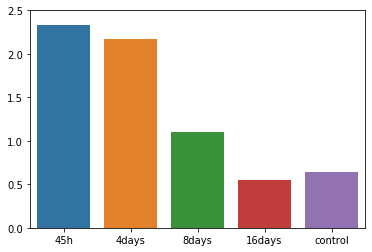

In [11]:
res_df = pd.DataFrame(columns=sorted_exp_key_list)

for exp_key in sorted_exp_key_list:
    sel_merged_df  = merged_df[merged_df['exp_key']==exp_key]
    
    num_mdc = np.sum(sel_merged_df['mdc1_size']>mdc_size_th)
    num_nuc = len(sel_merged_df)
    mdc_ratio = np.round(num_mdc/num_nuc*100,3)
    print(exp_key+':', mdc_ratio)
    
    res_df[exp_key]=[mdc_ratio]

sns.barplot(data=res_df)
plt.ylim([0,2.5])

45h: 2.33
4days: 2.172
8days: 1.102
16days: 0.552
control: 0.647


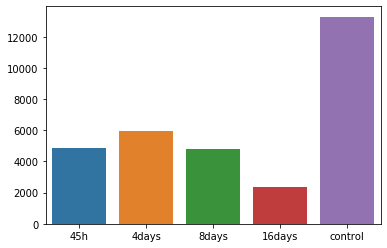

In [12]:
res_df = pd.DataFrame(columns=sorted_exp_key_list)

for exp_key in sorted_exp_key_list:
    sel_merged_df  = merged_df[merged_df['exp_key']==exp_key]
    
    num_mdc = np.sum(sel_merged_df['mdc1_size']>mdc_size_th)
    num_nuc = len(sel_merged_df)
    mdc_ratio = np.round(num_mdc/num_nuc*100,3)
    print(exp_key+':', mdc_ratio)
    
    res_df[exp_key]=[num_nuc]

sns.barplot(data=res_df)
#plt.ylim([0,2.5])

## 2.2 size filtering for nuclei

2898.0


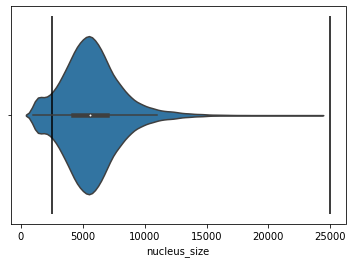

In [13]:
import seaborn as sns

sns.violinplot(merged_df['nucleus_size'])
plt.vlines(2500, -0.5, 0.5)
plt.vlines(25000, -0.5, 0.5)
print(np.percentile(merged_df['nucleus_size'], 10))

In [14]:
size_th_low =2000
size_th_high =25000

for exp_key in sorted_exp_key_list:
    sel_merged_df  = merged_df[merged_df['exp_key']==exp_key]
    ori_cell_num = len(sel_merged_df)
    
    sel_merged_df=sel_merged_df[sel_merged_df['nucleus_size']>size_th_low]
    sel_merged_df=sel_merged_df[sel_merged_df['nucleus_size']<size_th_high]
    print (f'-- There are {round(len(sel_merged_df)/ori_cell_num*100,0)}% data-points were kept after filtering.')
    
    num_mdc = np.sum(sel_merged_df['mdc1_size']>mdc_size_th)
    num_nuc = len(sel_merged_df)
    mdc_ratio = np.round(num_mdc/num_nuc*100,3)
    print(exp_key+':', mdc_ratio)

-- There are 89.0% data-points were kept after filtering.
45h: 2.607
-- There are 95.0% data-points were kept after filtering.
4days: 2.293
-- There are 93.0% data-points were kept after filtering.
8days: 1.18
-- There are 92.0% data-points were kept after filtering.
16days: 0.599
-- There are 98.0% data-points were kept after filtering.
control: 0.659


## 2.3 size and coord filtering for nuclei

In [15]:
def filter_cell_by_coord (xyz_coord_str, bound1=2048, bound2=0, dist_tp_bound = 600):
    
    xy_coord_str = xyz_coord_str.split('],')[0].split('[[')[-1]
    # note here xy is symetric; otherwise need to check which is x and which is y
    x=int(xy_coord_str.split(',')[0])
    y=int(xy_coord_str.split(',')[1])
    
    if abs(x-bound1)>=dist_tp_bound and abs(y-bound1)>=dist_tp_bound:
        if abs(x-bound2)>=dist_tp_bound and abs(y-bound2)>=dist_tp_bound:
            result= 1
        else:
            result= 0
    else:
        result= 0
    return result



-- There are 69.0% data-points were kept after filtering.
45h: 2.798 in 3360 cells
-- There are 73.0% data-points were kept after filtering.
4days: 2.349 in 4343 cells
-- There are 72.0% data-points were kept after filtering.
8days: 1.278 in 3443 cells
-- There are 70.0% data-points were kept after filtering.
16days: 0.543 in 1658 cells
-- There are 73.0% data-points were kept after filtering.
control: 0.697 in 9755 cells


(0, 3)

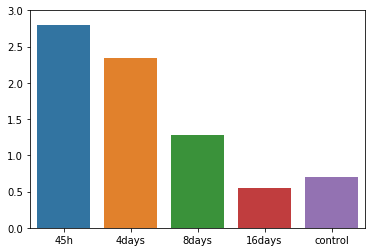

In [18]:
res_df = pd.DataFrame(columns=sorted_exp_key_list)


for exp_key in sorted_exp_key_list:
    sel_merged_df  = merged_df[merged_df['exp_key']==exp_key]
    ori_cell_num = len(sel_merged_df)
    
    sel_merged_df=sel_merged_df[sel_merged_df['nucleus_size']>size_th_low]
    sel_merged_df=sel_merged_df[sel_merged_df['nucleus_size']<size_th_high]
    
    sel_merged_df['pos_kept']=sel_merged_df['cell_xyz_coord'].map(lambda x: filter_cell_by_coord(x,dist_tp_bound = 200))
    sel_merged_df=sel_merged_df[sel_merged_df['pos_kept']==1]
    print (f'-- There are {round(len(sel_merged_df)/ori_cell_num*100,0)}% data-points were kept after filtering.')
    
    num_mdc = np.sum(sel_merged_df['mdc1_size']>mdc_size_th)
    num_mdc = np.sum(sel_merged_df['mdc1_mdc1_norm_intensity']>=1)
    
    num_nuc = len(sel_merged_df)
    mdc_ratio = np.round(num_mdc/num_nuc*100,3)
    print(exp_key+':', mdc_ratio, f'in {num_nuc} cells')
    
    
    res_df[exp_key]=[mdc_ratio]

sns.barplot(data=res_df)
plt.ylim([0,3])

In [17]:
mdc_size_th

200

In [19]:
res_df

,45h,4days,8days,16days,control
0,2.798,2.349,1.278,0.543,0.697


In [20]:
sel_merged_df

,exp_name,position_id,cell_id,cell_xyz_coord,mdc1_size,nucleus_size,mdc1_relative_size,mdc1_mdc1_intensity,nucleus_mdc1_intensity,noncell_mdc1_intensity,mdc1_mdc1_norm_intensity,exp_annotation,exp_key,mdc_Ab,pos_kept
4,220621exp_cov1,220621 RPE1 p53ko control Mdc1-488 H2AX-568_.n...,6,"[[1059, 304], 3]",0,13141,0.0,NaN,108.094818,106.096410,NaN,220623IF_220601exp,control,rabbit,1
5,220621exp_cov1,220621 RPE1 p53ko control Mdc1-488 H2AX-568_.n...,7,"[[1421, 324], 2]",0,14436,0.0,NaN,107.990233,106.203520,NaN,220623IF_220601exp,control,rabbit,1
7,220621exp_cov1,220621 RPE1 p53ko control Mdc1-488 H2AX-568_.n...,9,"[[713, 341], 2]",0,7881,0.0,NaN,107.169014,105.657201,NaN,220623IF_220601exp,control,rabbit,1
8,220621exp_cov1,220621 RPE1 p53ko control Mdc1-488 H2AX-568_.n...,10,"[[1692, 424], 2]",0,6766,0.0,NaN,108.640851,106.026182,NaN,220623IF_220601exp,control,rabbit,1
10,220621exp_cov1,220621 RPE1 p53ko control Mdc1-488 H2AX-568_.n...,12,"[[945, 518], 2]",0,7327,0.0,NaN,109.059506,106.019432,NaN,220623IF_220601exp,control,rabbit,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,230118_comtrol_40x,230118 RPE1 p53ko control Mdc1rb-488 H2AX-561 ...,16,"[[615, 919], 1]",0,5541,0.0,NaN,299.218914,126.637831,NaN,210126IF_230118exp_p53ko_control,control,rabbit,1
1261,230118_comtrol_40x,230118 RPE1 p53ko control Mdc1rb-488 H2AX-561 ...,17,"[[649, 1107], 1]",0,5809,0.0,NaN,316.904975,116.170479,NaN,210126IF_230118exp_p53ko_control,control,rabbit,1
1262,230118_comtrol_40x,230118 RPE1 p53ko control Mdc1rb-488 H2AX-561 ...,18,"[[1185, 1120], 1]",0,3125,0.0,NaN,598.290240,113.357499,NaN,210126IF_230118exp_p53ko_control,control,rabbit,1
1263,230118_comtrol_40x,230118 RPE1 p53ko control Mdc1rb-488 H2AX-561 ...,19,"[[349, 1164], 1]",0,5357,0.0,NaN,198.777301,110.783100,NaN,210126IF_230118exp_p53ko_control,control,rabbit,1


In [21]:
data_main_folder
np.unique(sel_merged_df['exp_annotation'])
np.unique(sel_merged_df['exp_key'])


array(['control'], dtype=object)

In [22]:
output_fname = os.path.join(data_main_folder,'40x_rabbit_MDC1_filtered_3_rep.xlsx')
with pd.ExcelWriter(output_fname) as writer:  
    
    for exp_key in sorted_exp_key_list:
        sel_merged_df  = merged_df[merged_df['exp_key']==exp_key]
        ori_cell_num = len(sel_merged_df)

        sel_merged_df=sel_merged_df[sel_merged_df['nucleus_size']>size_th_low]
        sel_merged_df=sel_merged_df[sel_merged_df['nucleus_size']<size_th_high]

        sel_merged_df['pos_kept']=sel_merged_df['cell_xyz_coord'].map(lambda x: filter_cell_by_coord(x,dist_tp_bound = 200))
        sel_merged_df=sel_merged_df[sel_merged_df['pos_kept']==1]
        print (f'-- There are {round(len(sel_merged_df)/ori_cell_num*100,0)}% data-points were kept after filtering.')

        num_mdc = np.sum(sel_merged_df['mdc1_size']>mdc_size_th)
        num_mdc = np.sum(sel_merged_df['mdc1_mdc1_norm_intensity']>=1)

        num_nuc = len(sel_merged_df)
        mdc_ratio = np.round(num_mdc/num_nuc*100,3)
        print(exp_key+':', mdc_ratio, f'in {num_nuc} cells')


        sel_merged_df.to_excel(writer,sheet_name=exp_key)
        print(f'--Saving excel for {exp_key}')

-- There are 69.0% data-points were kept after filtering.
45h: 2.798 in 3360 cells
--Saving excel for 45h
-- There are 73.0% data-points were kept after filtering.
4days: 2.349 in 4343 cells
--Saving excel for 4days
-- There are 72.0% data-points were kept after filtering.
8days: 1.278 in 3443 cells
--Saving excel for 8days
-- There are 70.0% data-points were kept after filtering.
16days: 0.543 in 1658 cells
--Saving excel for 16days
-- There are 73.0% data-points were kept after filtering.
control: 0.697 in 9755 cells
--Saving excel for control
